# Breadth Indicators
This notebooks aim is to show how breadth-indicators can be created with data from Börsdatas API.
I personally use a local DB that mirrors the Börsdata-API-layout but to simplify things for the general user
we will fetch all stock data and store it locally in a "pickle", which we then can read from to speed up things.

All of these indicators utilizes the same pattern. A big dataframe with an unique identifer, in this case **stock_id**, that is used with pandas groupby into apply with a custom function for data manipulation.

For further information regarding the groupby function [this](https://towardsdatascience.com/all-about-pandas-groupby-explained-with-25-examples-494e04a8ef56#:~:text=The%20groupby%20is%20one%20of,values%20for%20the%20generated%20groups.) might be useful.

Lets go!

In [127]:
import borsdata_client as bc
import borsdata_api as bd
import os
import constants
import pandas as pd
import numpy as np
# holidays is needed to remove holiday data that somehow seem to end up in the price data.
# pip3 install holidays
import holidays
import datetime as dt
import matplotlib.dates as mdates
import matplotlib.pyplot as plt


if os.path.isfile(constants.EXPORT_PATH + "data.pickle"):
    symbols = pd.read_pickle(constants.EXPORT_PATH + "data.pickle")
else:
    client = bc.BorsdataClient()
    client.get_all_stock_data_and_save_to_disk()


### Net new highs (yearly ~252 days/year)
The cumulative sum of net highs is preferably in a rising manner, especially if you like me trades breakouts.

In [128]:
import constants
import pandas as pd


def add_turnvover(df: pd.DataFrame) -> pd.DataFrame:
    df["turnover"] = df["close"] * \
        df["volume"] if df["country"].values[0] != "finland" else df["close"]*df["volume"]*10
    df["turnover_sma20"] = df["turnover"].rolling(20).mean()
    return df


# read stored pickle with all stock data
symbols = pd.read_pickle(constants.EXPORT_PATH + "data.pickle")

# I like to filter on turnover to get rid of turds (very thin stocks)
# So lets add turnover columns before removing the
# metadata needed for that and overwrite the data.pickle.
if not "turnover" in symbols.columns:
    symbols = symbols.groupby("stock_id", as_index=False).apply(
        lambda x: add_turnvover(x))
    symbols.to_pickle(constants.EXPORT_PATH + "data.pickle")

# Since we don"t need the metadata any longer and it can cause trouble with sum/mean functions we drop it.
symbols.drop(["name", "ticker", "sector", "branch",
             "market", "country"], axis=1, inplace=True)

# helper functions
def remove_swedish_holidays(df: pd.DataFrame) -> pd.DataFrame:
    holi = holidays.CountryHoliday(
        "SE", years=range(1999, dt.datetime.today().year + 1))
    df["date"] = pd.to_datetime(df["date"])
    df.set_index(df["date"], inplace=True)
    df = df[~df.index.isin(holi)]
    # monday=0, sunday=6
    df = df[df.index.dayofweek < 5]
    df.reset_index(inplace=True, drop=True)
    # klämdag kristihimmelsfärd
    df = df[df["date"] != dt.datetime(2020, 5, 22)]
    df = df[df["date"] != dt.datetime(2021, 5, 13)]
    df = df[df["date"] != dt.datetime(2022, 5, 26)]
    return df


def format_chart(axes):
    plt.subplots_adjust(wspace=0, hspace=0)
    for ax in axes:
        ax.grid()
        ax.legend()
        # if last ax
        if ax == axes[-1]:
            months = mdates.MonthLocator()
            ax.xaxis.set_major_locator(months)
            ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
            # rotating labels 45 degrees for readability
            for label in ax.xaxis.get_ticklabels():
                label.set_rotation(45)

# default window=252 to approximate number of businessdays in a year
def calculate_new_high_low(df, window=252, column="close", turnover_limit=2.5e6):
    df["new_high"] = np.where((df[column] >= df[column].rolling(window).max()) &
                              (df["turnover_sma20"] > turnover_limit), 1, 0)
    df["new_low"] = np.where((df[column] <= df[column].rolling(window).min()) &
                             (df["turnover_sma20"] > turnover_limit), 1, 0)
    return df


# remove holidays
symbols = remove_swedish_holidays(symbols)
# calculate new highs and lows
temp = symbols.groupby("stock_id", as_index=False).apply(
    lambda x: calculate_new_high_low(x)).copy()
# sum all values by date to get total number of highs and lows
summed = temp.groupby("date").sum()
# calculated the difference
summed["diff"] = summed["new_high"] - summed["new_low"]
# calculated the cumulative sum of the difference
summed["diff_cumsum"] = summed["diff"].cumsum()
summed["diff_cumsum_sma50"] = summed["diff_cumsum"].rolling(50).mean()


We now have created all the data needed for the next step; visualization of the data.

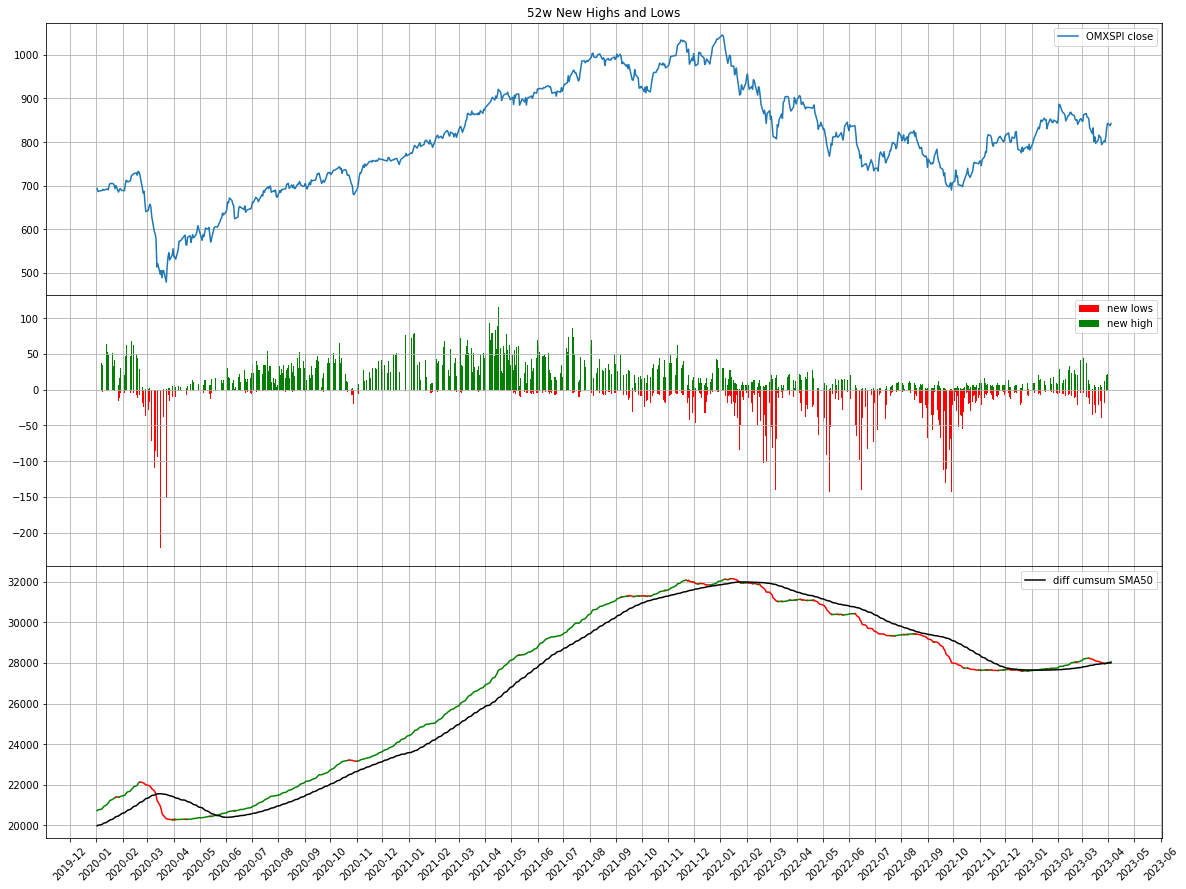

In [129]:
# create an API-instance to be able to get index data
api = bd.BorsdataAPI(constants.API_KEY)
# get omxspi data for plot, stock_id=638
omxspi = api.get_instrument_stock_prices(638)
# modifying figsize for bigger plot
plt.rcParams["figure.figsize"] = [20, 15]
fig, ax = plt.subplots(3, sharex=True)
# convert index to datettime
summed.index = pd.to_datetime(summed.index)
# set start date of both frames to be plotted to 2020-01-01
start_date = dt.datetime(2020, 1, 1)
summed = summed[summed.index > start_date]
omxspi = omxspi[omxspi.index > start_date]
# some special calculations for colored cumulative-sum plot
summed["difference"] = summed["diff_cumsum"].diff()
summed["condition"] = (summed["difference"] > 0).astype(int)
summed["group"] = summed["condition"].diff(
).abs().cumsum().fillna(0).astype(int) + 1
green = summed["condition"].iloc[1] == 1
last = pd.DataFrame()
ax[0].set_title("52w New Highs and Lows")
ax[0].plot(omxspi["close"], label="OMXSPI close")
ax[1].bar(summed.index, -summed["new_low"], label="new lows", color="red")
ax[1].bar(summed.index, summed["new_high"], label="new high", color="green")
for i in range(1, summed.group.max() + 1):
    group = pd.concat(
        [last, summed["diff_cumsum"][summed.group == i]])
    last = group.iloc[-1:]
    green = not green
    ax[2].plot(group, color="green" if green else "red")
ax[2].plot(summed["diff_cumsum_sma50"],
           label="diff cumsum SMA50", color="black")
format_chart(ax)
plt.show()


We can clearly see that the market lost its momentum around September 2021 and then went sideways for a bit before breaking down.
Since then we've been in an down trend, grinding below the 50-day moving average.

## Moving average breadth
The next breadth indicator measures the amount of stocks trading above a certain moving average.

In [130]:
def is_above_ma(df, ma=50):
    df[f"above_ma{ma}"] = np.where(
        df["close"] >= df["close"].rolling(ma).mean(), 1, 0)
    return df


temp = symbols.groupby("stock_id", as_index=False).apply(
    lambda x: is_above_ma(x)).copy()
mean = temp.groupby("date").mean()
mean.index = pd.to_datetime(mean.index)


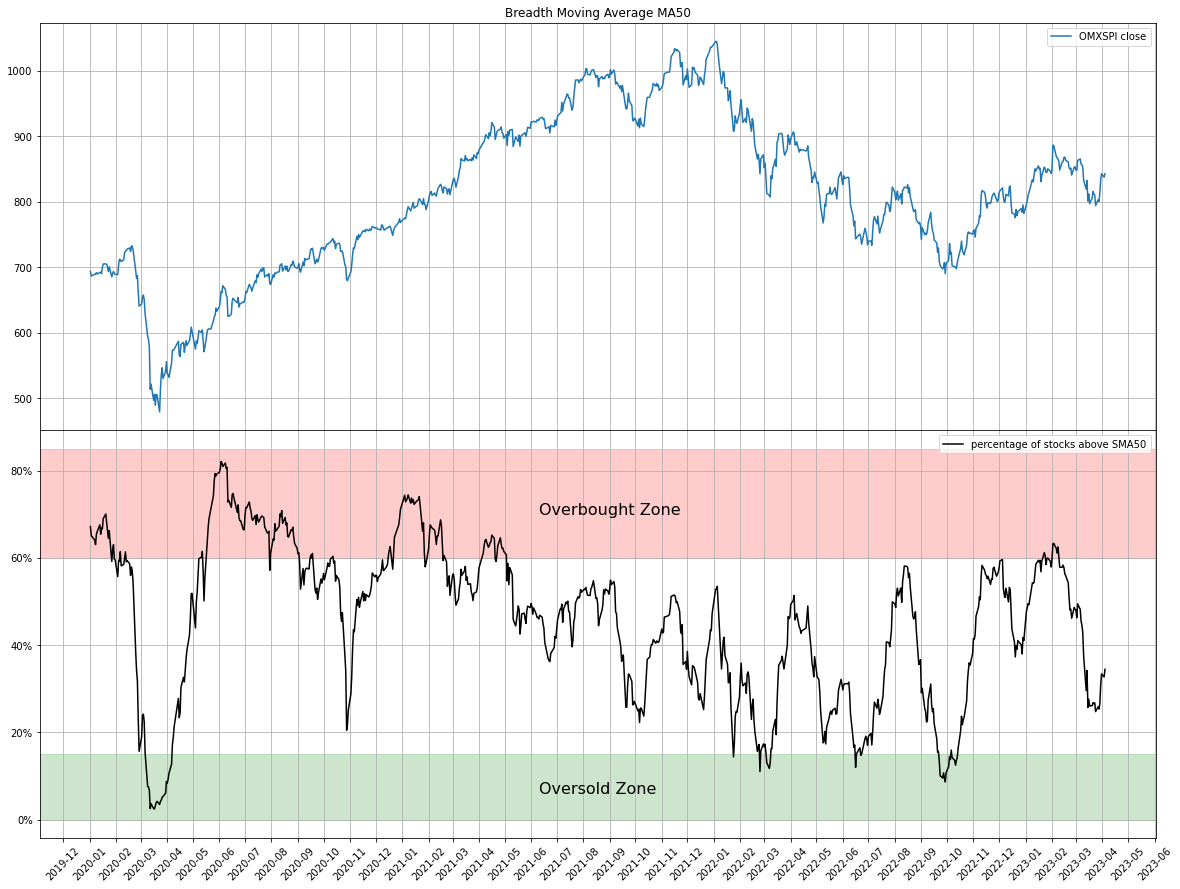

In [131]:
from matplotlib.ticker import PercentFormatter

fig, ax = plt.subplots(2, sharex=True)
mean = mean[mean.index >= start_date]
ax[0].plot(omxspi["close"], label="OMXSPI close")
ax[1].plot(mean["above_ma50"],
           label="percentage of stocks above SMA50", color="black")
ax[1].axhspan(0, 0.15, color="green", alpha=0.2)
ax[1].text(mean.index[360], 0.06, "Oversold Zone", fontsize=16)
ax[1].axhspan(0.6, 0.85, color="red", alpha=0.2)
ax[1].text(mean.index[360], 0.7, "Overbought Zone", fontsize=16)
format_chart(ax)

# set %-format on y-axis
ax[1].yaxis.set_major_formatter(PercentFormatter(1.0))
ax[0].set_title("Breadth Moving Average MA50")
plt.show()


## McClellan Oscillator
Measures advancing and declining stocks and the relationship between them, it mimics a MACD-indicator but for advances vs declines.
Rising SummationIndex marks strong trend. In this example we are using the ratio-adjusted approach, for more information about the calculation and how to use the indicator see [link](https://www.mcoscillator.com/learning_center/kb/market_data/ratio_adjusted_summation_index/).

In [132]:
def calculate_advance_and_decline(df, volume_limit=1e5, turnover_limit=2.5e6):
    # added some liquidity filter here for stocks to get rid of turds
    df["advance"] = np.where((df["close"].pct_change() > 0) & (
        (df["volume"] > volume_limit) | (df["turnover_sma20"] > turnover_limit)), 1, 0)
    df["decline"] = np.where((df["close"].pct_change() < 0) & (
        (df["volume"] > volume_limit) | (df["turnover_sma20"] > turnover_limit)), 1, 0)
    return df


temp = symbols.groupby("stock_id", as_index=False).apply(
    lambda x: calculate_advance_and_decline(x)).copy()
temp = temp.groupby("date").sum()
temp.index = pd.to_datetime(temp.index)
temp = temp[temp.index > start_date]
# ran = ratio adjusted advance-decline
temp["ran"] = ((temp["advance"] - temp["decline"]) /
               (temp["advance"] + temp["decline"])) * 1000

temp["ad_fast"] = temp["ran"].ewm(alpha=0.1).mean()
temp["ad_slow"] = temp["ran"].ewm(alpha=0.05).mean()
temp["osc"] = temp["ad_fast"] - temp["ad_slow"]
temp["summation_index"] = temp["osc"].cumsum()
temp["summation_index_ma10"] = temp["summation_index"].rolling(10).mean()


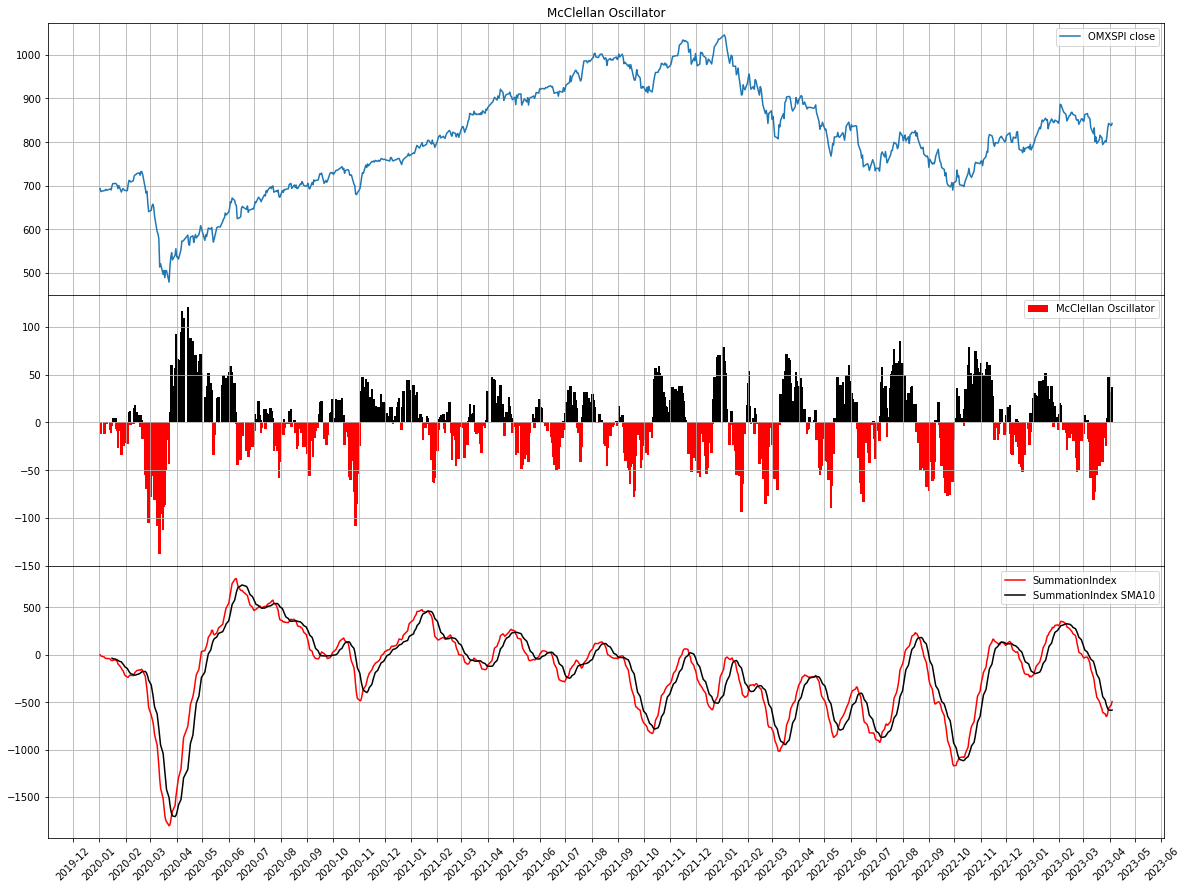

In [133]:
fig, ax = plt.subplots(3, sharex=True)
ax[0].plot(omxspi["close"], label="OMXSPI close")
ax[1].bar(temp.index, temp["osc"], label="McClellan Oscillator", color=(
    temp["osc"] > 0).map({True: "black", False: "red"}), width=3, alpha=1)
ax[2].plot(temp["summation_index"], label="SummationIndex", color="red")
ax[2].plot(temp["summation_index_ma10"],
           label="SummationIndex SMA10", color="black")
format_chart(ax)
ax[0].set_title("McClellan Oscillator")
plt.show()


## Zweig Breadth Thrust Indicator
Measures the ratio between advances and declines.

In [134]:
temp = symbols.groupby("stock_id", as_index=False).apply(
    lambda x: calculate_advance_and_decline(x)).copy()
temp = temp.groupby("date").sum()
temp.index = pd.to_datetime(temp.index)

# ewm is ema
temp["breadth"] = (temp["advance"] / (temp["advance"] +
                   temp["decline"])).ewm(span=10, adjust=False).mean()
temp["breadth_thrust"] = np.where((temp["breadth"] >= 0.58) & (
    temp["breadth"].rolling(10).min() <= 0.4), 1, np.nan)
temp = temp[temp.index > start_date]


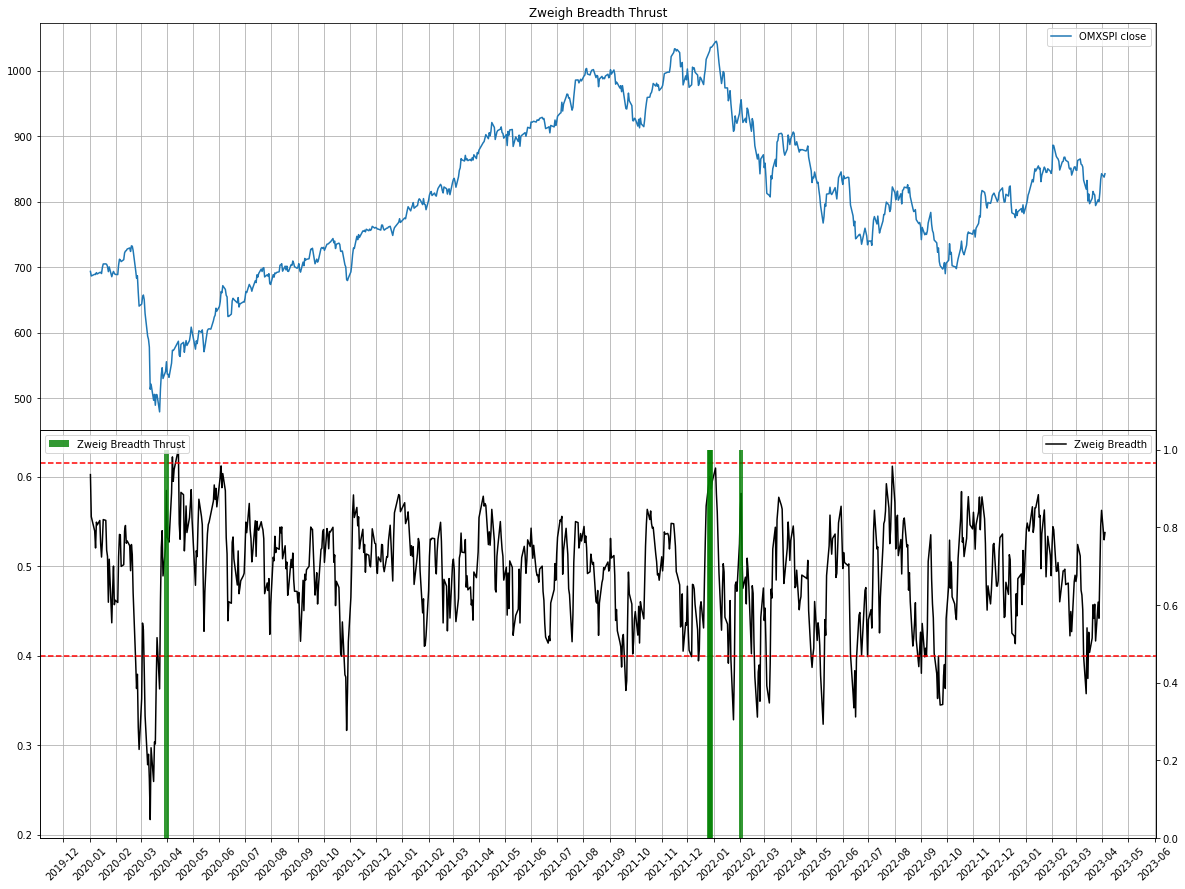

In [135]:
fig, ax = plt.subplots(2, sharex=True)
ax[0].plot(omxspi["close"], label="OMXSPI close")
ax[1].plot(temp["breadth"], label="Zweig Breadth", color="black")
ax1_tw = ax[1].twinx()
ax1_tw.bar(temp.index, temp["breadth_thrust"],
           label="Zweig Breadth Thrust", color="green", width=5, alpha=0.8)
format_chart(ax)
ax1_tw.legend()
ax[1].axhline(0.615, linestyle="--", color="red")
ax[1].axhline(0.4, linestyle="--", color="red")
ax[0].set_title("Zweigh Breadth Thrust")
plt.show()


The standard Zweig-Breadth-Thrust is defined as a move from 0.4 -> 0.615 in less than two weeks (10-days), there is no signal for the Nordic markets with those settings for the chosen widnow, so for the purpose of this example I've lowered the threshold a bit to 0.58.
For more information regarding the indicator see [ZweigBreadthThrust](https://www.quantifiedstrategies.com/zweig-breath-thrust-indicator/).

## Upside Day
Measure upside volume in relation to downside volume, this is a "bottoming" indicator, more information [here](https://tradethatswing.com/when-to-buy-stocks-after-a-stock-market-correction/#:~:text=Lowry%20Upside%20Days%20To%20Signal,to%20one%2090%25%20upside%20day.)

In [136]:
def calculate_up_down_volume(df):
    df["up_volume"] = np.where(
        (df["close"].pct_change() > 0), df["volume"], np.nan)
    df["down_volume"] = np.where(
        (df["close"].pct_change() < 0), df["volume"], np.nan)
    return df


temp = symbols.groupby("stock_id", as_index=False).apply(
    lambda x: calculate_up_down_volume(x))
summed = temp.groupby("date").sum()
summed["omxspi_close"] = omxspi["close"]
summed["vol_ratio_up"] = summed["up_volume"] / \
    (summed["up_volume"] + summed["down_volume"])
summed["vol_ratio_down"] = summed["down_volume"] / \
    (summed["up_volume"] + summed["down_volume"])
# I"ve added the ma50 criteria, since this is a bottoming indicator and most bottoms occur below ma50...
summed["vol_ratio_up_90"] = np.where((summed["vol_ratio_up"] > 0.9) & (
    summed["omxspi_close"] < summed["omxspi_close"].rolling(50).mean()), summed["omxspi_close"], np.nan)
summed = summed[summed.index > start_date]


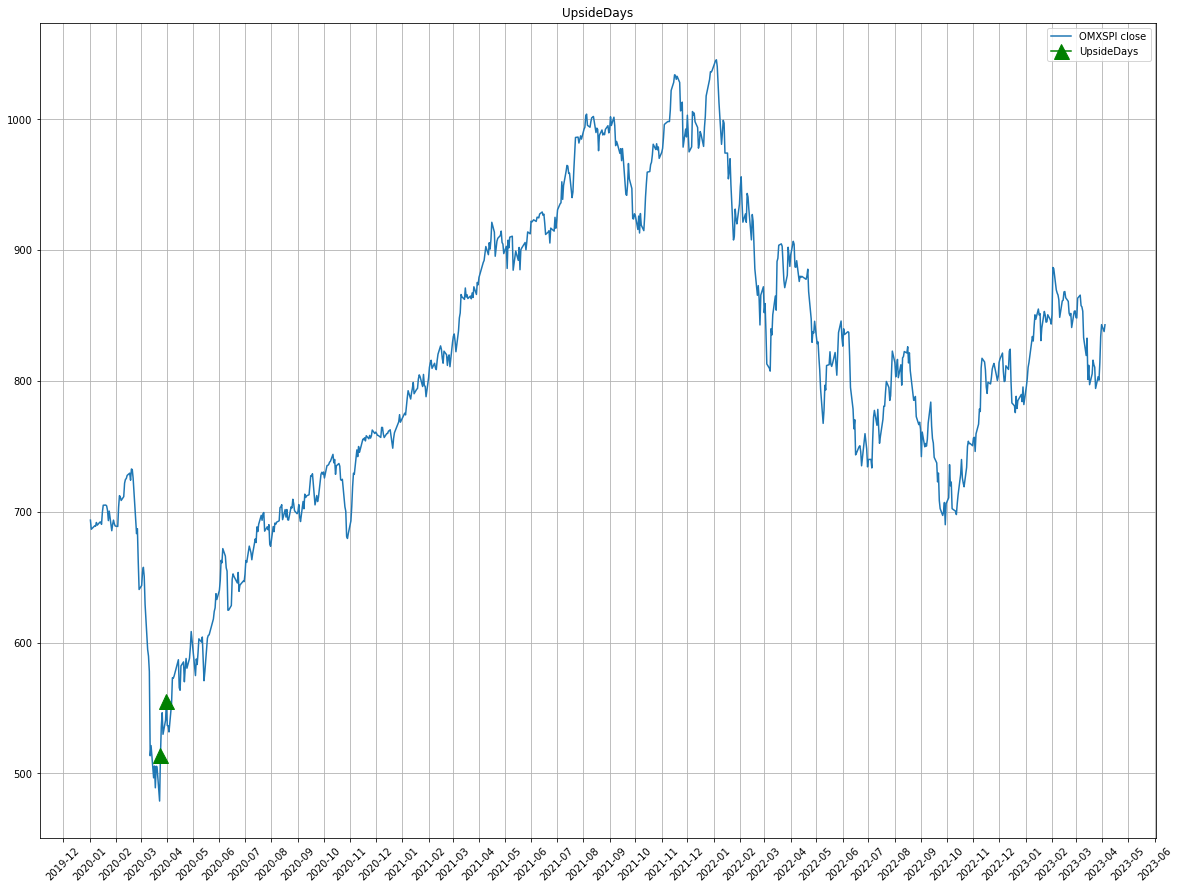

In [137]:
# plot the chart
fig, ax = plt.subplots(1, sharex=True)
ax.plot(summed["omxspi_close"], label="OMXSPI close")
ax.plot(summed["vol_ratio_up_90"], label="UpsideDays",
        color="green", marker="^", markersize=15)
ax.legend()
ax.grid()
months = mdates.MonthLocator()
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
# rotating labels 45 degrees for readability
for label in ax.xaxis.get_ticklabels():
    label.set_rotation(45)
ax.set_title("UpsideDays")
plt.show()


## Pradeeps (Stockbee) Market Monitor
[Stockbee](https://twitter.com/PradeepBonde) has developed a tool which he calls MarketMonitor (MM). He updates it regulary for the US-markets [here](https://stockbee.blogspot.com/p/mm.html).

More information regarding the formulas involved in the monitor can be found [here](https://stockbee.blogspot.com/2018/08/market-monitor-scans.html).

Market monitor walk-through [here](https://www.youtube.com/watch?v=XMtlW9ZuU0M).

Let's create our own for the Nordics! 

In [138]:
def calculate_market_monitor_attributes(df: pd.DataFrame, turnover_limit=2.5e6, volume_limit=1e5) -> pd.DataFrame:
    turnover_criteria_up_down = df["volume"] > volume_limit
    turnover_criteria = df["turnover_sma20"] > turnover_limit
    df["up4"] = np.where((df["close"].pct_change() > 0.04) &
                          (df["volume"] > df["volume"].shift()) &
                            turnover_criteria_up_down, 1, 0)
    df["down4"] = np.where((df["close"].pct_change() < -0.04) &
                           (df["volume"] > df["volume"].shift()) &
                             turnover_criteria_up_down, 1, 0)
    df["up25quarter"] = np.where(
        ((df["close"] / df["close"].rolling(65).min() - 1) >= 0.25) & turnover_criteria, 1, 0)
    df["down25quarter"] = np.where(
        ((df["close"] / df["close"].rolling(65).max() - 1) <= -0.25) & turnover_criteria, 1, 0)
    df["up25month"] = np.where(
        (df["close"].pct_change(20) > 0.25) & turnover_criteria, 1, 0)
    df["down25month"] = np.where(
        (df["close"].pct_change(20) < -0.25) & turnover_criteria, 1, 0)
    df["up50month"] = np.where(
        (df["close"].pct_change(20) > 0.5) & turnover_criteria, 1, 0)
    df["down50month"] = np.where(
        (df["close"].pct_change(20) < -0.5) & turnover_criteria, 1, 0)
    df["up13"] = np.where((((df["close"] - df["close"].rolling(34).min())/df["close"].rolling(
        34).min()) > 0.13 ) & turnover_criteria, 1, 0)
    df["down13"] = np.where((((df["close"] - df["close"].rolling(34).max())/df["close"].rolling(
        34).max()) < -0.13) & turnover_criteria, 1, 0)
    # t2108 refers to tc2000 own index with stocks above sma40
    df["t2108"] = np.where( (df["close"] > df["close"].rolling(40).mean()) & turnover_criteria, 1, 0)
    df["total_stocks"] = np.where(turnover_criteria, 1, 0)
    return df


# create mm-data, feel free to play around with different limits for turnover and volume.
market_monitor = symbols.groupby("stock_id", as_index="False").apply(
    lambda x: calculate_market_monitor_attributes(x, 2_500_000, 100_000)).copy()
# sum over the date
market_monitor = market_monitor.groupby("date").sum()
# calculate 5/10-day ratios
market_monitor["5day_ratio"] = market_monitor["up4"].rolling(
    5).sum() / market_monitor["down4"].rolling(5).sum()
market_monitor["10day_ratio"] = market_monitor["up4"].rolling(
    10).sum() / market_monitor["down4"].rolling(10).sum()
market_monitor["t2108"] = market_monitor["t2108"] / market_monitor["total_stocks"] 
# reorganize columns
market_monitor = market_monitor[["up4", "down4", "5day_ratio", "10day_ratio", "up25quarter",
                                 "down25quarter", "up25month", "down25month", "up50month", "down50month", "up13", "down13", "t2108", "total_stocks"]]
# save to excel
market_monitor.to_excel(constants.EXPORT_PATH + "market_monitor.xlsx")
print(market_monitor.tail(10).to_string())


            up4  down4  5day_ratio  10day_ratio  up25quarter  down25quarter  up25month  down25month  up50month  down50month  up13  down13     t2108  total_stocks
date                                                                                                                                                             
2023-03-22   28     48    0.754630     0.440876          104             90         13           12          6            4    62     214  0.274678           466
2023-03-23   38     33    0.752294     0.444772          107             84         12           12          6            4    68     204  0.290043           462
2023-03-24   35    100    0.666667     0.465991           82            104         10           15          6            3    58     245  0.233624           458
2023-03-27   35     37    0.715447     0.577586           91             98          9           18          5            3    67     215  0.269565           460
2023-03-28   29     54    0.

You can see the tail (the end of the frame) above, feel free to play around with different values for the turnover and volume limits for the monitor.

That's it folks! Hope you had a great time and you learned something new!
Any questions or errors just give me a DM on [Twitter](https://twitter.com/TapeReaderJoe).

Peace! 